# 

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import optuna
from sklearn.model_selection import cross_val_score

data = pd.read_csv("../Data/D-FENSE/merged_d-fense.csv")

print(data.head(6))

   epiweek  cases   temp_min   temp_med   temp_max  precip_min  precip_med  \
0   201001   3539  21.658084  25.004341  29.274303    0.012281    0.302680   
1   201001     22  24.048092  26.776109  30.772313    0.002407    0.082629   
2   201001    208  23.877589  26.699426  30.751801    0.015402    0.285009   
3   201001   4256  22.527846  25.419562  29.649180    0.021887    0.373958   
4   201001    210  22.065314  25.423990  29.700304    0.003048    0.076435   
5   201001     75  23.267653  26.596911  30.972213    0.000440    0.061565   

   precip_max   precip_tot region  
0    1.230068  1128.998094     SP  
1    0.371142    41.649765     SE  
2    1.101980   367.566872     PA  
3    1.414037   484.254513     MT  
4    0.324229   105.137269     PE  
5    0.317397     9.340346     RR  


# Data Encoding / Rescaling

In [2]:
# convert to log-scale
data['cases'] = np.log1p(data['cases'])

In [3]:
# apply encodings
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# data['region'] = one_hot_encoder.fit_transform(data.loc[:, ['region']])
label_encoder = LabelEncoder()
data['region'] = label_encoder.fit_transform(data.loc[:, ['region']])


/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# train, test, validate split
# this is a split for time-series data.
n_size = data.shape[0]
x_train = data.drop(columns=['cases'])[:int(0.7 * n_size)]
y_train = data['cases'][:int(0.7 * n_size)]
x_val = data.drop(columns=['cases'])[int(0.7 * n_size):int(0.85 * n_size)]
y_val = data['cases'][int(0.7 * n_size):int(0.85 * n_size)]
x_test = data.drop(columns=['cases'])[int(0.85 * n_size):]
y_test = data['cases'][int(0.85 * n_size):]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)
#x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['cases']), data["cases"], test_size=.2)

(11793, 9)
(11793,)
(2528, 9)
(2528,)
(2527, 9)
(2527,)


# Hyperparameter Tuning

In [5]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    objective = "reg:squarederror"
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, objective=objective, random_state=42)
    score = np.mean(cross_val_score(model, x_train,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    return score

    #model.fit(x_train, y_train)
    #y_pred = model.predict(x_test)
    #rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    #return rmse

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)



[I 2025-04-07 00:03:23,941] A new study created in memory with name: no-name-e5af45a5-a9f1-4850-8e23-17fe0bbd2acd
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-pack

In [6]:

print(study.best_params)
# Train final model with best parameters
bst = xgb.XGBRegressor(**study.best_params, random_state=42)

{'n_estimators': 272, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 19}


# Model Training

In [7]:
# setup model for XGboost 
bst.fit(x_train,y_train)



/home/yoshixi/Documents/epicdemics/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:06:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, min_samples_leaf=19,
             min_samples_split=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=272, ...)

[4.6198883 3.6228063 5.43502   3.8325949 4.594348  8.215642  6.047796
 4.9653444 5.6706505 4.6872206]
[7.7102051944325325, 1.0986122886681096, 8.039157390473237, 5.771441123130016, 4.672828834461906, 7.823245690685523, 5.003946305945459, 4.219507705176107, 7.312553498102598, 4.499809670330265]
mean absolute : 1.322273483144234
RMSE : 1.7161493919994835
mean squared : 2.945168735660197
r2 score: 0.2225900847304092


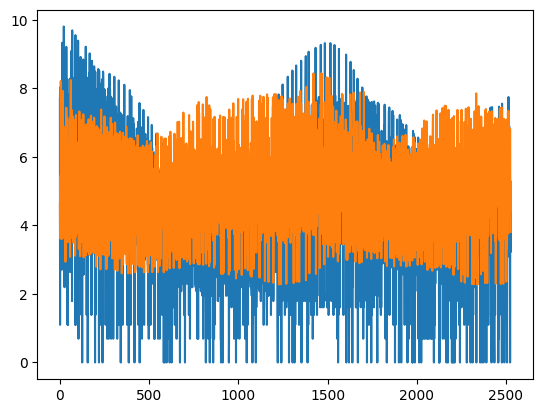

In [12]:
preds = bst.predict(x_test)
print(preds[0:10])
print(list(y_test)[0:10])
print(f"mean absolute : {mean_absolute_error(y_test, preds)}")
print(f"RMSE : {root_mean_squared_error(y_test, preds)}")
print(f"mean squared : {mean_squared_error(y_test, preds)}")
print(f"r2 score: {r2_score(y_test,preds)}")
plt.plot(np.arange(y_test.shape[0]), y_test)
plt.plot(np.arange(preds.shape[0]), preds)

[4.6198883 3.6228063 5.43502   3.8325949 4.594348  8.215642  6.047796
 4.9653444 5.6706505 4.6872206]
[7.7102051944325325, 1.0986122886681096, 8.039157390473237, 5.771441123130016, 4.672828834461906, 7.823245690685523, 5.003946305945459, 4.219507705176107, 7.312553498102598, 4.499809670330265]
mean absolute : 406.66583501575866
RMSE: 1102.9993958752489
mean squared : 1216607.667301164
r2 score: 0.12185582250026339


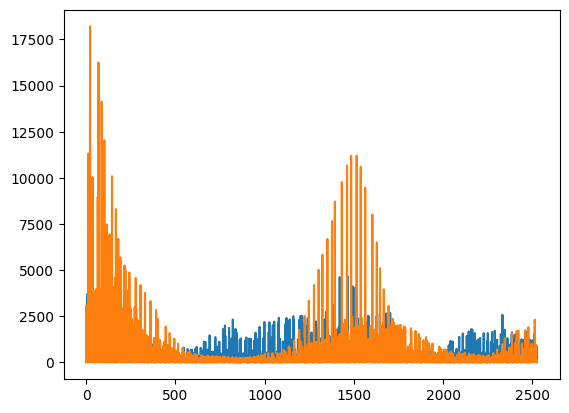

In [13]:
origpreds = np.expm1(preds)
origytest = np.expm1(y_test)
print(preds[0:10])
print(list(y_test)[0:10])
print(f"mean absolute : {mean_absolute_error(origytest, origpreds)}")
print(f"RMSE: {root_mean_squared_error(origytest, origpreds)}")
print(f"mean squared : {mean_squared_error(origytest, origpreds)}")
print(f"r2 score: {r2_score(origytest,origpreds)}")

plt.plot(np.arange(origpreds.shape[0]), origpreds)
plt.plot(np.arange(origytest.shape[0]), origytest)


In [10]:
bst.save_model("xgboostmodel.json")